# Machine Learning Titanic 
### SVM GridSearch
SVM provides .78 accuracy which is near the best performing models below. Therefore, an extensive tunning using GridSearchCV will be used to help perfect SVM models. 

My newest, high performing models:
* All initial models:
https://github.com/ScottySchmidt/Kaggle/blob/main/Titanic.ipynb
* Decision tree scores top 6%
https://github.com/ScottySchmidt/Kaggle/blob/main/dtree.ipynb
* xgBoost top 5%
https://github.com/ScottySchmidt/Kaggle/blob/main/xgbTop5%25.ipynb
* Random forest top 5%
https://github.com/ScottySchmidt/Kaggle/blob/main/forestTop5%25.ipynb

### KNN GridSearch
KNN initially provided the worse accuracy results. Even with additional tunning using GridSearchCV, KNN still does not provide good results. 

# Metrics
The gradient classifier and logistic regression are the best two models that provide the highest best score. Interestingly, the gradient classifier does not have a high AUC but the results cross validate into the test dataset without overfitting the data. For example, decision tree can get an almost perfect AUC but when you cross validate the data it is clearly overfiting. 

# Train Data
Train.csv will contain the details of a subset of the passengers on board (891 to be exact) and whether they survive or not. The shape of the train data is (891, 12). 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from statistics import mean
from sklearn.metrics import accuracy_score, classification_report, mean_absolute_error, mean_squared_error, r2_score
from sklearn.datasets import make_classification
from sklearn import ensemble
import sklearn.metrics as metrics
import time
from math import sqrt

train=r'/kaggle/input/titanic/train.csv'
test=r'/kaggle/input/titanic/test.csv' 

df=pd.read_csv(train)
test=pd.read_csv(test)

print(df.shape)
df.head()

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [2]:
df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [3]:
#Check Duplicates:
dupstr = df.duplicated()
print('Total no of duplicate values in Training Dataset = %d' % (dupstr.sum()))
df[dupstr]

Total no of duplicate values in Training Dataset = 0


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked


In [4]:
#search for columns with missing values:
def findNA():
    print("Missing data by column as a percent:")
    findNA=df.isnull().sum().sort_values(ascending=False)/len(df)
    print(findNA.head())
findNA() 

Missing data by column as a percent:
Cabin          0.771044
Age            0.198653
Embarked       0.002245
PassengerId    0.000000
Survived       0.000000
dtype: float64


# Feature Engineer
We need to replace male and female into numbers. This is a very important part of the process because gender is one of the highest predictors on if a person survived or not.

In [5]:
#GENDER
df['Sex']=df['Sex'].map({'female':0,'male':1})

Females whose number is 0 had a much higher chance of surving than males. Later on, doing the importance feature analysis we will view that gender is actually one of the highest predictors. 

In [6]:
genderTable = pd.crosstab(df['Survived'],df['Sex'])
genderTable

Sex,0,1
Survived,,
0,81,468
1,233,109


# Encode Categorical Variables
Encode Categorical Variables is needed for this dataset since there are many important variables that are not numeric yet. 

There are three classes C, Q, and S. Class C seems to have the highest chance of survival. Class S has the lowest chance of survival. Unfornately this would tend to show that economic status seems to played a part in the decision if someone survived or not. Embarked does not play role major role in feature importance. 

In [7]:
import category_encoders as ce
#encoder = ce.OrdinalEncoder(cols=['Embarked'])

#df = encoder.fit_transform(df)
#test = encoder.fit_transform(test)
#test.head()

# Examine Target Variable
Survived is the Y variable we will be analyzing. Since the survival rete is 0.384 the data is not considered unbalanced. 

In [8]:
temp=df['Survived'].value_counts()
print(temp)
no=temp[0]
yes=temp[1]
percent=round(yes/(yes+no),3)
print("Percent that survived: ", percent)

0    549
1    342
Name: Survived, dtype: int64
Percent that survived:  0.384


# Numeric DataFrame
For now, we will analyze only numeric values. Categorical values will need to be encoded or analyzed individually.

In [9]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
df = df.select_dtypes(include=numerics)
df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
0,1,0,3,1,22.0,1,0,7.2500
1,2,1,1,0,38.0,1,0,71.2833
2,3,1,3,0,26.0,0,0,7.9250
3,4,1,1,0,35.0,1,0,53.1000
4,5,0,3,1,35.0,0,0,8.0500


# Check for missing values
Age is missing around 20% of values.Therefore, we can simply fill in the mean for that one column.

In [10]:
#search for columns with missing values:
def findNA():
    print("Missing data by column as a percent:")
    findNA=df.isnull().sum().sort_values(ascending=False)/len(df)
    print(findNA.head())
findNA() 

Missing data by column as a percent:
Age            0.198653
PassengerId    0.000000
Survived       0.000000
Pclass         0.000000
Sex            0.000000
dtype: float64


In [11]:
df= df.fillna(df.mean())

# Split Data

In [12]:
X=df.drop('Survived', axis=1)
y=df['Survived']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.20, random_state = 42)

# Highly Correlated Features
There are no highly correlated variables above 80%. Therefore, we do not need to be concerned about removing variables that are too highly correlated. 

<AxesSubplot:>

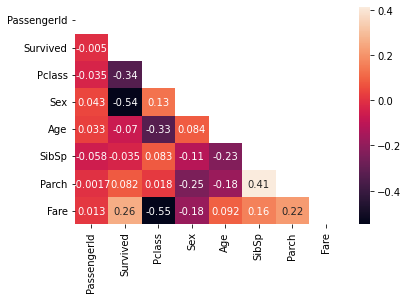

In [13]:
import seaborn as sns
corr= df.corr()
matrix = np.triu(corr)
sns.heatmap(corr, annot=True, mask=matrix)

# K-Nearest Neighbors (KNN)
Initial tuning provides around a .59 AUC. This model does not seem to be very effective on this dataset.

n_neighbors = 3 provides the least amount of error:

In [14]:
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor

def knnError():
    numbers=list(range(1, 16, 2))
    error_rates = []
    accList=[]
    for n in numbers: #Must be an odd number to break a tie
        new_model = KNeighborsClassifier(n_neighbors =  n)
        new_model.fit(X_train, y_train)
        y_pred = new_model.predict(X_test)
        error_rates.append(np.mean( y_pred != y_test))
        knn_auc = round( metrics.roc_auc_score(y_test,  y_pred), 4 ) 
        accList.append(knn_auc)
    plt.plot(numbers, error_rates)
    plt.title("KNN Error n_neighbors")
    plt.xlabel("n_neighbors")
    plt.ylabel("Error Rate")
    plt.show()
    
    plt.plot(numbers, accList)
    plt.title("Knn Accuracy ")
    plt.xlabel("n_neighbors")
    plt.ylabel("Accuracy")
    plt.show()
#knnError() 

In [15]:
def knnLeaf():
    error_rates = []
    accList=[]
    numbers=list(range(1,50))
    for n in numbers: 
        new_model = KNeighborsClassifier(leaf_size =  n)
        new_model.fit(X_train, y_train)
        y_pred = new_model.predict(X_test)
        error_rates.append(np.mean(y_pred != y_test))
        knn_auc = round( metrics.roc_auc_score(y_test,  y_pred), 4 ) 
        accList.append(knn_auc)
        #print("Knn AUC: ", knn_auc)
    plt.plot(numbers, error_rates)
    plt.title("KNN Error")
    plt.xlabel("leaf_size")
    plt.ylabel("Error Rate")
    plt.show()
    
    plt.plot(numbers, accList)
    plt.title("Knn Accuracy ")
    plt.xlabel("leaf_size")
    plt.ylabel("Accuracy")
    plt.show()
#knnLeaf() 

# KNN GridSearch

In [16]:
def knnGrid():
    n_neighbors = list(range(1, 16, 2))
    p=[1,2]

    print("start")
    params=dict(n_neighbors=n_neighbors, p=p, metric= ['euclidean', 'manhattan'])
    grid=GridSearchCV(KNeighborsClassifier(), params, cv=5, scoring='accuracy')
    knnGrid=grid.fit(X, y)
    print(knnGrid.best_estimator_)
#knnGrid()

# Final KNN Prediction

In [17]:
knnFinal = KNeighborsClassifier(n_neighbors =15, p=1, metric='manhattan')

#FIT and PREDICT:
knnFinal.fit(X_train, y_train)
y_pred =  knnFinal.predict_proba(X_test)[::,1]

#calculate AUC of model
knn_auc = round( metrics.roc_auc_score(y_test, y_pred ), 4 ) 
print("Knn AUC: ", knn_auc)
error = round(sqrt(mean_squared_error(y_test, y_pred )), 4)
print("MSE ", error)

Knn AUC:  0.6859
MSE  0.467


# Support Vector 
The initial results for SVM AUC with no parameter tunning is 0.5336. Tunning the model gets AUC to be almost 80%. 

#### GridSearch Tune
The best parameters from tunning SVM is SVC(C=1000, gamma=0.0001).

In [18]:
from sklearn.svm import SVC

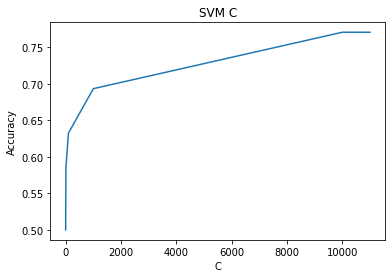

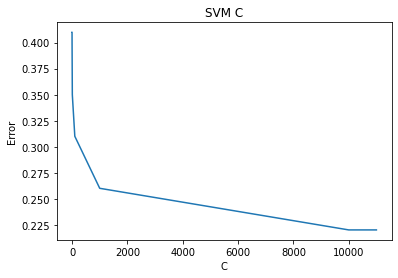

In [19]:
def svmC():
    numbers=[.0001, .001, .01, .1, 1, 10, 100, 1000, 10_000, 11_000]
    maeList=[]
    accList=[]
    for n in numbers:
        svm=SVC(C=n)
        svm.fit(X_train, y_train)
        y_pred=svm.predict(X_test)
        
        mae=metrics.mean_absolute_error(y_test, y_pred).round(2)
        auc=metrics.roc_auc_score(y_test, y_pred).round(4)
        maeList.append(mae)
        accList.append(auc)
    plt.plot(numbers, accList)
    plt.title("SVM C")
    plt.xlabel("C")
    plt.ylabel("Accuracy")
    plt.show()
    
    plt.plot(numbers, maeList)
    plt.title("SVM C")
    plt.xlabel("C")
    plt.ylabel("Error")
    plt.show()
svmC()

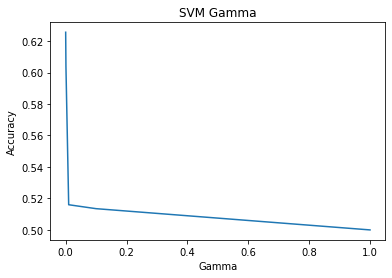

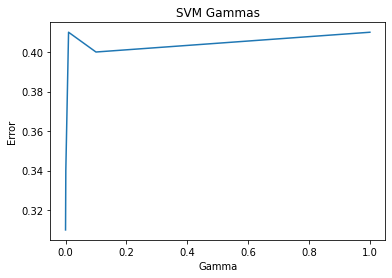

In [20]:
def svmGamma():
    numbers=[.0001, .001, .01, .1, 1]
    maeList=[]
    accList=[]
    for n in numbers:
        svm=SVC(gamma=n)
        svm.fit(X_train, y_train)
        y_pred=svm.predict(X_test)
        
        mae=metrics.mean_absolute_error(y_test, y_pred).round(2)
        auc=metrics.roc_auc_score(y_test, y_pred).round(4)
        maeList.append(mae)
        accList.append(auc)
    plt.plot(numbers, accList)
    plt.title("SVM Gamma")
    plt.xlabel("Gamma")
    plt.ylabel("Accuracy")
    plt.show()
    
    plt.plot(numbers, maeList)
    plt.title("SVM Gammas")
    plt.xlabel("Gamma")
    plt.ylabel("Error")
    plt.show()
svmGamma()

In [21]:
def svmGrid():
    print("start")
    param_grid = {'C': [100, 1000, 10_000],
                  'gamma': [0.0001],
                  'kernel': ['rbf'],
                  #'probability':[True,False],
                 }

    grid = GridSearchCV(SVC(), param_grid, cv=10, scoring='accuracy', verbose = False)
    grid.fit(X_train, y_train)
    print(grid.best_params_)
    print(grid.best_estimator_)
svmGrid()

start
{'C': 10000, 'gamma': 0.0001, 'kernel': 'rbf'}
SVC(C=10000, gamma=0.0001)


# Final SVM Prediction
Best GridSearchCV from above:
* Using CV=10 gets best AUC {'C': 10000, 'gamma': 0.0001, 'kernel': 'rbf'}
* SVC(C=10_000, gamma=.0001, kernel = 'linear')   --> AUC is:  0.7933
* SVC(C=1000, gamma=0.0001)
* SVC(C=100, gamma=1)

SVC AUC is:  0.8065
SVM Score:  0.8268
              precision    recall  f1-score   support

           0       0.81      0.92      0.86       105
           1       0.86      0.69      0.77        74

    accuracy                           0.83       179
   macro avg       0.84      0.81      0.81       179
weighted avg       0.83      0.83      0.82       179



<Figure size 360x504 with 0 Axes>

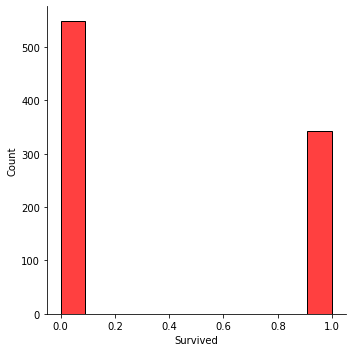

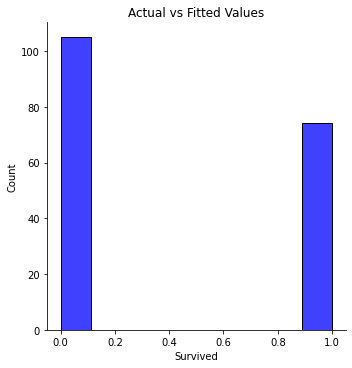

In [22]:
#Fit and Predict:
svmFinal=SVC(C=10_000, gamma=.0001, kernel = 'linear')
svmFinal.fit(X_train, y_train)
y_pred = svmFinal.predict(X_test)

#calculate AUC of model
svmAUC = metrics.roc_auc_score(y_test, y_pred, multi_class='ovr').round(4)
print("SVC AUC is: ", svmAUC)

svmR2 = r2_score(y_test, y_pred).round(4) 
svmMAE=metrics.mean_absolute_error(y_test, y_pred).round(4)

print("SVM Score: ", svmFinal.score(X_test, y_test).round(4))
print(classification_report(y_test, y_pred))

plt.figure(figsize=(5, 7))
ax = sns.displot(y,  color="r", label="Actual Value")
sns.displot(y_test, color="b", label="Fitted Values")
plt.title('Actual vs Fitted Values')
plt.show()

Text(0.5, 1.0, 'SVM rbf Decision Region Boundary')

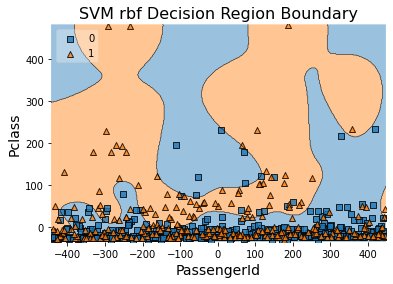

In [23]:
from sklearn.decomposition import PCA
from mlxtend.plotting import plot_decision_regions
import numpy as np

clf = SVC(C=1000, gamma=0.0001, kernel = 'rbf')
pca = PCA(n_components = 2)
X_train2 = pca.fit_transform(np.array(X_train))
y_train2=np.array(y_train)
clf.fit(X_train2, y_train2)
plot_decision_regions(X_train2, y_train2, clf=clf, legend=2)

plt.xlabel(X.columns[0], size=14)
plt.ylabel(X.columns[1], size=14)
plt.title('SVM rbf Decision Region Boundary', size=16)

Text(0.5, 1.0, 'SVM sigmoid Decision Region Boundary')

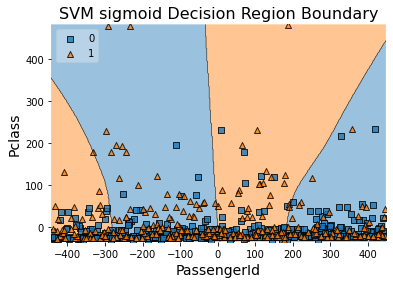

In [24]:
clf = SVC(C=1000, gamma=0.0001, kernel = 'sigmoid')
pca = PCA(n_components = 2)
X_train2 = pca.fit_transform(np.array(X_train))
y_train2=np.array(y_train)
clf.fit(X_train2, y_train2)
plot_decision_regions(X_train2, y_train2, clf=clf, legend=2)

plt.xlabel(X.columns[0], size=14)
plt.ylabel(X.columns[1], size=14)
plt.title('SVM sigmoid Decision Region Boundary', size=16)

In [25]:
def linear():
    clf = SVC(C=1000, gamma=0.0001, kernel = 'linear')
    pca = PCA(n_components = 2)
    X_train2 = pca.fit_transform(np.array(X_train))
    y_train2=np.array(y_train)
    clf.fit(X_train2, y_train2)
    plot_decision_regions(X_train2, y_train2, clf=clf, legend=2)

    plt.xlabel("X_train2", size=14)
    plt.ylabel("y_train2", size=14)
    plt.title('SVM Linear Decision Region Boundary', size=16)
    plt.show()

# Test Data

In [26]:
#GENDER
test['Sex']=test['Sex'].map({'female':0,'male':1})

features=list(X.columns)
test=test[features]

test=test.fillna(test.mean())
test.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare
0,892,3,1,34.5,0,0,7.8292
1,893,3,0,47.0,1,0,7.0000
2,894,2,1,62.0,0,0,9.6875
3,895,3,1,27.0,0,0,8.6625
4,896,3,0,22.0,1,1,12.2875


# Final Prediction

In [27]:
test_predictions = svmFinal.predict(test)
passID=test['PassengerId']
tupleData = list(zip(passID, test_predictions))
output = pd.DataFrame(tupleData, columns = ['PassengerId', 'Survived'])
output.head(7)

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
5,897,0
6,898,0


In [28]:
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


#### Notes:
Being a wife makes no difference in the final prediction: <br>
` df['Titles'] = df['Name'].str.extract(r', (\w+\.)') 
df['Titles'] = df['Titles'].apply(lambda x: 1 if x=='Mrs.' else 0) `